# Bayesian Parameter Estimation
Guest lecture by Prof. Rachel Kurchin

## Getting set up...
Let's import some packages and do some stuff to make our plots look nice...

In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform
from scipy.special import gamma
from itertools import product
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Bayes' Rule example: disease testing
Given a test for a disease with a given **sensitivity** ($P(\text{positive test}|\text{patient is sick}$) and **specificity** ($P(\text{negative test}|\text{patient is healthy})$), what is the chance that you are sick, given that you receive a positive test result?

Bayes' Rule says...

$$P(\text{sick}|+)=\frac{P(+|\text{sick})P(\text{sick})}{P(+)}$$

We can recgnize the first term in the numerator as the sensitivity. The second term is the prevalence of the illness in the population, while the denominator is the overall positivity rate, which we can compute as:

$$P(+) = P(+|\text{sick})P(\text{sick}) + P(+|\text{healthy})P(\text{healthy})$$

Recognizing a few terms, we can rewrite our original expression as

$$P(\text{sick}|+) = \frac{\text{sensitivity}\times\text{prevalence}}{\text{sensitivity}\times\text{prevalence} + (1-\text{specificity})(1-\text{prevalence})}$$

In [11]:
def prob_sick(sens, spec, prev):
    numer = sens * prev
    denom = sens * prev + (1-spec)*(1-prev)
    return numer/denom

Let's explore how this expression depends on some of the variables. For simplicitity, we'll start by assuming that sensitivity and specificity are equal and see how the $P(\text{sick}|+)$ varies with them under different assumptions of prevalence.

In [40]:
prevalence = widgets.FloatSlider(
    value=0.5,
    min=0.02,
    max=0.98,
    step=0.02,
    description='Prevalence:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

@interact(prev=prevalence, spec=specificity)
def plot_prob(prev):
    ss = np.linspace(0.4, 0.99, 50)
    probs_1p = [prob_sick(s, s, 0.01) for s in ss]
    probs_99p = [prob_sick(s, s, 0.99) for s in ss]
    probs_slider = [prob_sick(s, s, prev) for s in ss]
    plt.plot(ss, probs_1p, color='lightgrey', label="prevalence=1%")
    plt.plot(ss, probs_99p, color='dimgrey', label="prevalence=99%")
    plt.plot(ss, probs_slider, label="prevalence=slider")
    plt.plot([0.4, 1.0], [prev, prev], '--k', label="prob=prevalence (prior)")
    plt.xlabel("Sensitivity/Specificity")
    plt.ylabel("P(sick|+)")
    plt.ylim([0,1.03])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

interactive(children=(FloatSlider(value=0.5, description='Prevalence:', max=0.98, min=0.02, step=0.02), Output…

Let this plot, and the relationships between the different things shown, sink in for awhile...okay now we'll do the (as we know from the COVID case) more realistic scenario where sensitivity and specificity can be different:

In [41]:
prevalence2 = widgets.FloatSlider(
    value=0.5,
    min=0.02,
    max=0.98,
    step=0.02,
    description='Prevalence:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

specificity2 = widgets.FloatSlider(
    value=0.6,
    min=0.4,
    max=0.98,
    step=0.02,
    description='Specificity:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

@interact(prev=prevalence2, spec=specificity2)
def plot_prob(prev, spec):
    sens = np.linspace(0.4, 0.99, 50)
    probs_1p = [prob_sick(s, spec, 0.01) for s in sens]
    probs_99p = [prob_sick(s, spec, 0.99) for s in sens]
    probs_slider = [prob_sick(s, spec, prev) for s in sens]
    plt.plot(sens, probs_1p, color='lightgrey', label="prevalence=1%")
    plt.plot(sens, probs_99p, color='dimgrey', label="prevalence=99%")
    plt.plot(sens, probs_slider, label="prevalence=slider")
    plt.plot([0.4, 1.0], [prev, prev], '--k', label="prob=prevalence (prior)")
    plt.xlabel("Sensitivity")
    plt.ylabel("P(sick|+)")
    plt.ylim([0,1.03])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

interactive(children=(FloatSlider(value=0.5, description='Prevalence:', max=0.98, min=0.02, step=0.02), FloatS…

## Bayesian Parameter Estimation (BPE)

**NOTE:** Example content in this section is all from [here](https://pv-lab.github.io/bayesim/_build/html/bayesics.html) so visit that link for more written-out explanations...

Model is simple parabolic trajectory:
$$M(v_0, g; t) = v_0t + \frac 12 gt^2$$

If we make a measurement at time $t=t_i$ of $y=y_i \pm \Delta y_i$ m, we assume a Gaussian uncertainty and model the "true" value of $y$ as:
$$P(y) \propto \exp\left({-\frac{(y-y_i)^2}{2*\Delta y_i^2}}\right)$$

The probability distribution over parameters $v_0$ and $g$ conditioned upon this measurement is thus:
$$P(v_0, g | y(t_i)=y_i \pm \Delta y_i) \propto \exp\left({-\frac{(M(v_0,g;t_i)-y_i)^2}{2*\Delta y_i^2}}\right)$$

In [43]:
def M_y(v_0, g, t): #model fcn
    return v_0 * t - 0.5*g*t**2

#likelihood fcn...calls model with given parameters and compares to "measured" result
def prob_y(v_0, g, t, meas_y, unc): 
    return (1/np.sqrt(2*np.pi*unc**2)) * np.exp(-(M_y(v_0, g, t)-meas_y)**2/(2*unc**2))

# set up grid of parameter values
v_0s = np.linspace(0,20,500)
gs = np.linspace(0,20,500)

Suppose we make a measurement of $y(t=2.0$ s$) = 3.0 \pm 0.2$ m. We can use our likelihood function with that data...

In [44]:
contour_pts = np.reshape([prob_y(v_0s[i], gs[j], 2.0, 3.0, 0.2) # call prob_y on the measurement 
                          for i in range(len(v_0s)) 
                          for j in range(len(gs))], (len(v_0s), len(gs))) # make it into a matrix of the shape we want

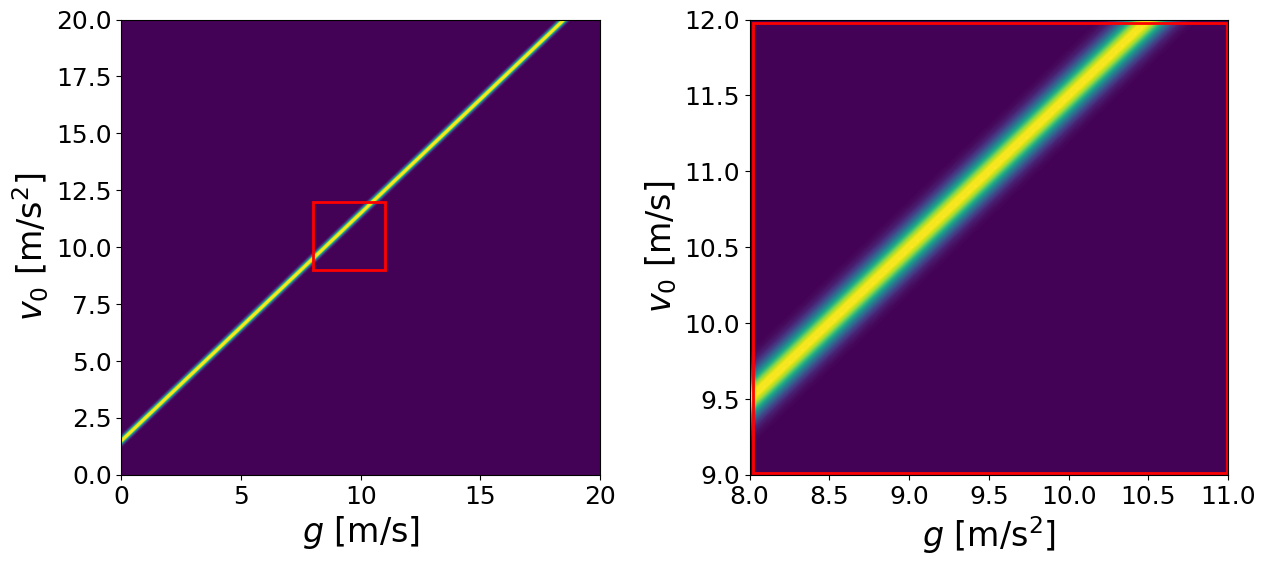

In [45]:
# now let's visualize this probability density
fig, ax = plt.subplots(1,2,figsize=(13,6))
plt.subplot(1,2,1)
plt.contourf(v_0s, gs, contour_pts, 100) # make contour plot

# plot aesthetics
rect=plt.Rectangle((8,9), 3, 3, fill=False, ec='r', linewidth=2)
plt.gca().add_patch(rect)
plt.xlabel('$g$ [m/s]')
plt.ylabel('$v_0$ [m/s$^2$]')
plt.xlim([0, 20])
plt.ylim([0, 20])

# zoomed-in region
plt.subplot(1,2,2)
plt.contourf(v_0s, gs, contour_pts, 100) # same data plotted

# plot aesthetic stuff...
rect=plt.Rectangle((8.02,9.01) ,2.97, 2.97, fill=False, ec='r', linewidth=2)
plt.gca().add_patch(rect)
plt.xlabel('$g$ [m/s$^2$]')
plt.ylabel('$v_0$ [m/s]')
plt.xlim([8.0, 11.0])
plt.ylim([9.0, 12.0])
plt.tight_layout()

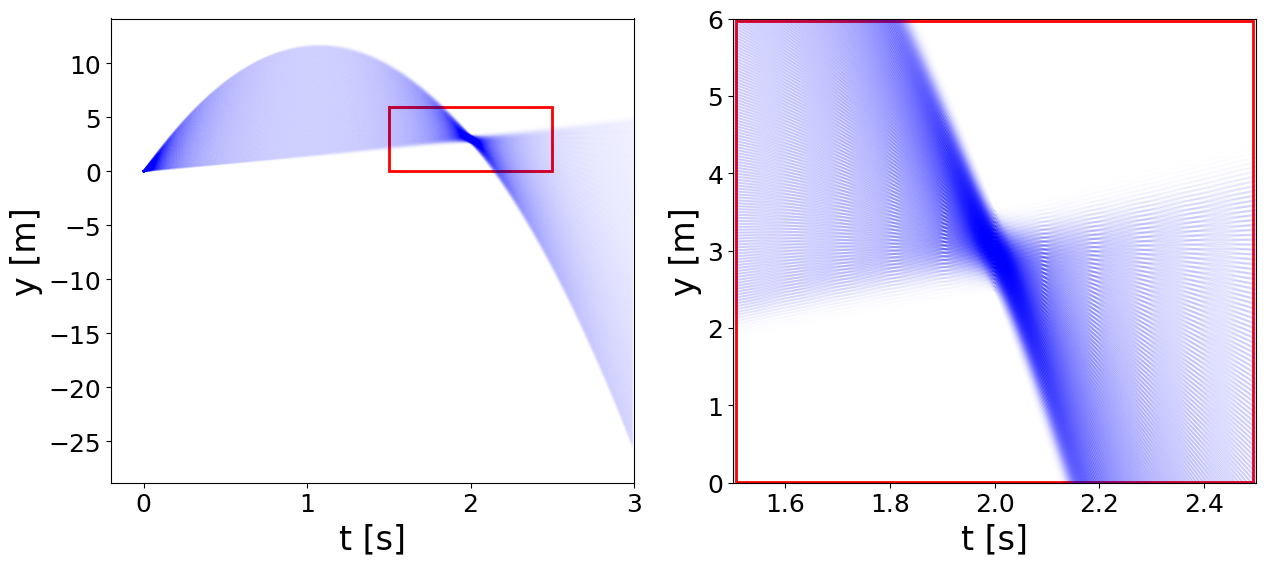

In [50]:
# What about the possible trajectories?

g_vals = np.linspace(0,20,40)
v0_start = np.linspace(0.9,2.1,50)
probs = {}

# compute probability of each combination
for g in g_vals:
    for v0_s in v0_start:
        v0 = v0_s+g
        probs[(v0,g)] = prob_y(v0, g, 2.0, 3.0, 0.2)

t_vals = np.arange(0,3.0,0.01)

fig, ax = plt.subplots(1,2,figsize=(13,6))
plt.subplot(1,2,1)

# plot trajectory for every combination with color saturation proportional to probability
for pair in probs.keys():
    plt.plot(t_vals, [M_y(pair[0], pair[1], t) for t in t_vals], alpha=probs[pair]/80.0, color='b')
    
# aesthetics
rect=plt.Rectangle((1.5,0), 1, 6, fill=False, ec='r', linewidth=2)
plt.gca().add_patch(rect)
plt.xlabel('t [s]')
plt.ylabel('y [m]')
plt.xlim([-0.2, 3.0])

# do again for zoomed-in view
plt.subplot(1,2,2)
for pair in probs.keys():
    plt.plot(t_vals, [M_y(pair[0], pair[1], t) for t in t_vals], alpha=probs[pair]/20.0, color='b')
rect=plt.Rectangle((1.505,0.01), 0.99, 5.955, fill=False, ec='r', linewidth=2)
plt.gca().add_patch(rect)
plt.xlabel('t [s]')
plt.ylabel('y [m]')
plt.xlim([1.5, 2.5])
plt.ylim([0,6])
plt.tight_layout()
plt.show()

Now let's imagine we took another measurement of $y(t=2.3$ s$) = 0.1 \pm 0.5$ m...

(6.0, 16.0)

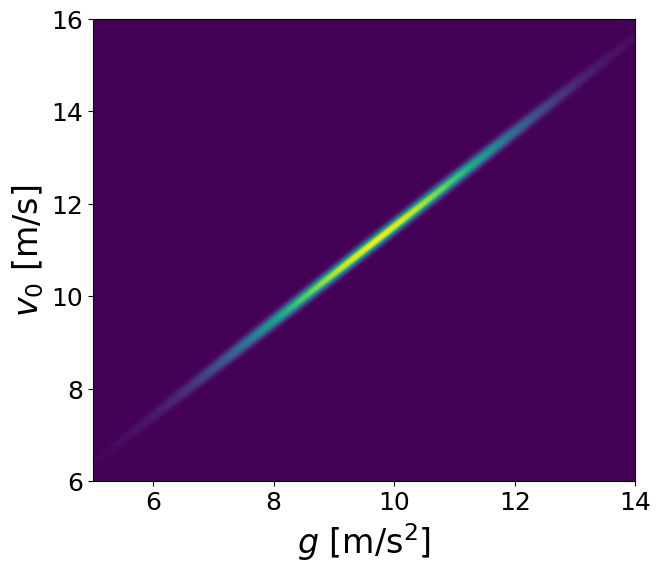

In [47]:
# compute and plot probabilities again

contour_pts = np.reshape([prob_y(v_0s[i], gs[j], 2.0, 3.0, 0.2) * prob_y(v_0s[i], gs[j], 2.3, 0.1, 0.5) 
                          for i in range(len(v_0s)) for j in range(len(gs))], (len(v_0s),len(gs)))
fig, ax = plt.subplots(figsize=(7,6))
plt.contourf(v_0s, gs, contour_pts, 100)
plt.xlabel('$g$ [m/s$^2$]')
plt.ylabel('$v_0$ [m/s]')
plt.grid(False)
plt.xlim([5,14])
plt.ylim([6,16])

And what do the possible trajectories look like now?

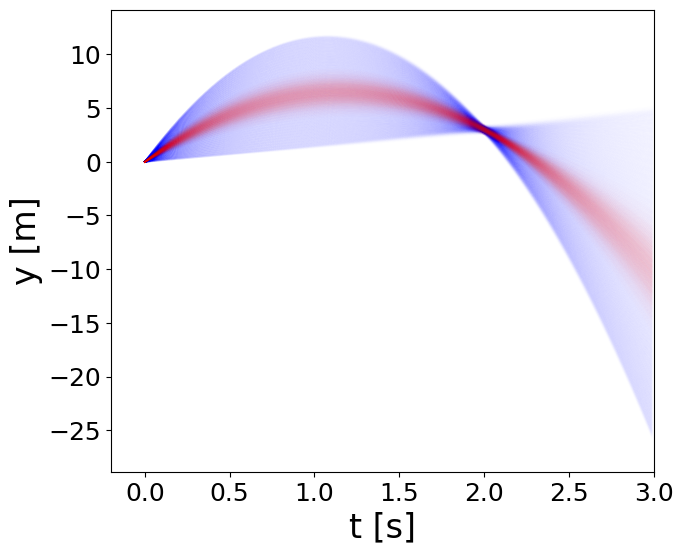

In [48]:
# calculate probs for points on grid
g_vals = np.linspace(5,15,25)
v0_start = np.linspace(0.9,2.1,25)
probs_next = {}
for g in g_vals:
    for v0_s in v0_start:
        v0 = v0_s+g
        probs_next[(v0,g)] = prob_y(v0, g, 2.0, 3.0, 0.2) * prob_y(v0, g, 2.3, 0.1, 0.5)

# and plot
t_vals = np.arange(0,3.0,0.01)
fig, ax = plt.subplots(figsize=(7,6))

# blue ones from before but more transparent
for pair in probs.keys():
    plt.plot(t_vals, [M_y(pair[0], pair[1], t) for t in t_vals], alpha=probs[pair]/100.0, color='b')

# and red for latest set
for pair in probs_next.keys():
    plt.plot(t_vals, [M_y(pair[0], pair[1], t) for t in t_vals], alpha=probs_next[pair]/20.0, color='r')
plt.xlabel('t [s]')
plt.ylabel('y [m]')
plt.xlim([-0.2, 3.0])
plt.grid(False)

We can use our distribution to ask other questions, too. Like suppose we were really only interested in the gravitational constant and not the $v_0$ (maybe to estimate the mass of the planet). We can *marginalize* over the $v_0$ distribution to see just the result for $g$...

9.69939879759519

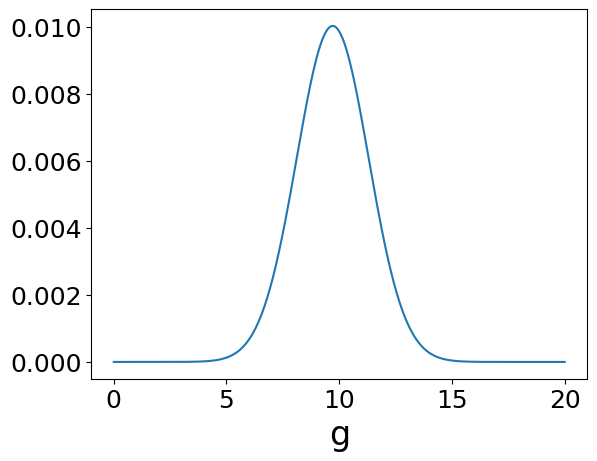

In [77]:
g_probs = np.sum(contour_pts, axis=0) # sum over v_0 axis
plt.plot(gs, g_probs/np.sum(g_probs)) # plot distribution
plt.xlabel("g")
gs[np.argmax(g_probs)] # get highest-probability value